# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: MLOps**

### Tecnológico de Monterrey

## **Fase 1 - Avance de proyecto - Equipo 7**
### **Problema de asignación de créditos: South German Dataset.**

### Dante Cesar Cervantes Gutierrez - A01794585 
### Luis Angel Benitez Ortega - A01795165
### Ignacio Jose Aguilar Garcia - A00819762
### Alan Jasso Arenas - A01383272 
### Andrea Jelena Ramírez García - A01733905 

## **Aplicación de Mejores Prácticas en el Pipeline de Modelado**

### Step 1: Importar Librerías

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_auc_score, roc_curve)
import yaml
from sklearn.model_selection import learning_curve

### Step 2: Cargar Configuración y Datos

In [5]:
with open(r'../../params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

df = pd.read_csv(config['data_load']['dataToModel'])

### Step 3: Preparar Variables de Entrada y Salida

In [6]:
X = df.drop(['credit_risk'], axis=1)  # Características
Y = df['credit_risk']  # Variable objetivo

### Step 4: Dividir el Conjunto de Datos

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


### Step 5: Definir Preprocesamiento

In [8]:
# Especificar nombres de características
var_num = ["duration", "amount", "age"]  # Características numéricas
var_nom = ["status", "credit_history", "purpose", "savings", "personal_status_sex", "housing"]  # Categóricas
var_ord = ["employment_duration", "installment_rate", "present_residence", "property", "number_credits", "job"]  # Ordinales
var_bin = ["telephone", "foreign_worker"]  # Variables binarias que pueden ser utilizadas en el modelo

# Crear pipelines para datos numéricos, ordinales y categóricos
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores nulos con la mediana
    ('scaler', MinMaxScaler(feature_range=(1, 2)))  # Escalar características numéricas
])

catImp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Imputar valores nulos en variables ordinales
])

catOHE_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-hot encoding para variables categóricas
])

# Combinar pasos de preprocesamiento en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, var_num),  # Pipeline para variables numéricas
        ('ord', catImp_pipeline, var_ord),  # Pipeline para variables ordinales
        ('cat', catOHE_pipeline, var_nom)   # Pipeline para variables categóricas
    ],
    remainder='passthrough'  # Mantener las columnas no transformadas
)

### Step 6: Construir el Pipeline Completo

In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=0))  # SVM con probabilidades
])

### Step 7: Definir Hiperparámetros para Optimización

In [10]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma': [0.1, 1, 10, 100]
}

### Step 8: Realizar la Busqueda de Cuadricula

In [11]:
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler(feature_range=(1,
                                                                                                                      2)))]),
                                                                         ['duration',
                                                                          'amount',
                                                                          'age']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['employment_...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings',
                                                                          'personal_status_sex',
                                                                          'housing'])])),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=0))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__gamma': [0.1, 1, 10, 100],
                         'classifier__kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='accuracy')

### Step 9: Obtener el Mejor Modelo y Hiperparametros

In [12]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

### Step 10: Evaluar el Modelo

In [13]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [14]:
# Calcular Métricas
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_test, y_test_pred)

In [15]:
# Imprimir Resultados
print("Best Hyperparameters:", best_params)
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Train F1 Score:", train_f1)
print("Validation F1 Score:", val_f1)

Best Hyperparameters: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'linear'}
Train Accuracy: 0.8484848484848485
Validation Accuracy: 0.73
Train F1 Score: 0.9047619047619048
Validation F1 Score: 0.8163265306122449


### Step 11: Matrix de Confusion y ROC Curve

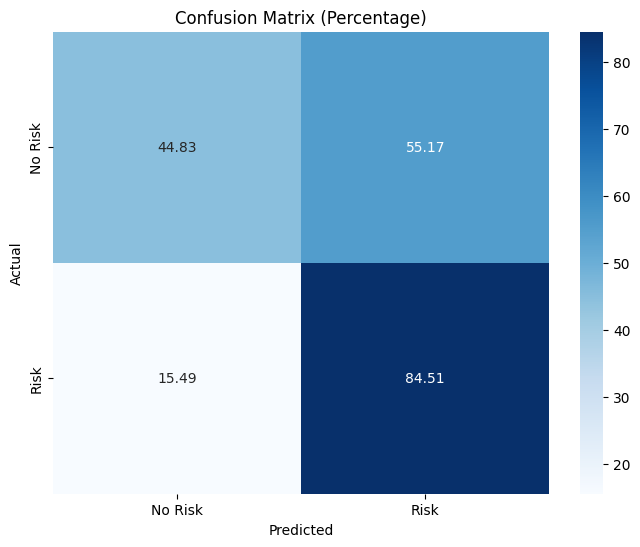

In [18]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calcular porcentajes
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Graficar la matriz de confusión con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Percentage)')
plt.show()

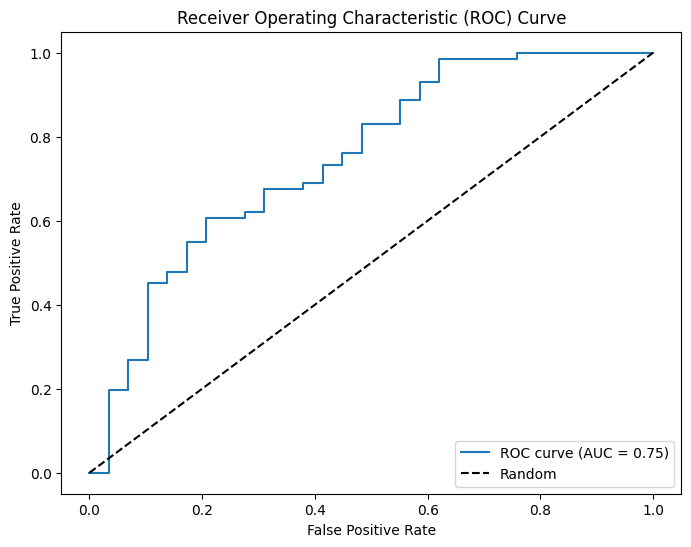

In [21]:
# Calcular ROC y AUC
scores_val = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, scores_val)
auc = roc_auc_score(y_test, scores_val)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


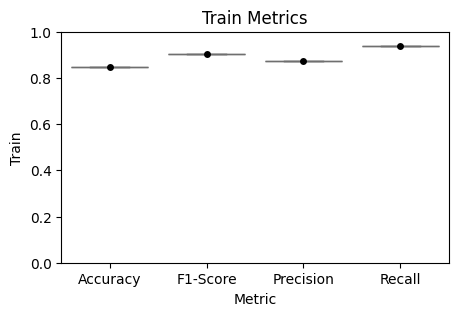

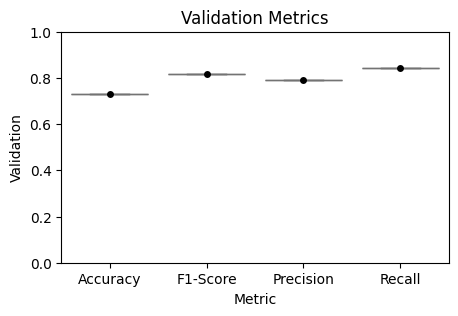

In [23]:
# Gráficas de Métricas de Entrenamiento y Validación
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'Precision', 'Recall'],
    'Train': [train_accuracy, train_f1, precision_score(y_train, y_train_pred), recall_score(y_train, y_train_pred)],
    'Validation': [val_accuracy, val_f1, precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)]
})

# Gráfica para Métricas de Entrenamiento
plt.figure(figsize=(5, 3))
sns.boxplot(data=metrics_df, x='Metric', y='Train', color='skyblue')
sns.stripplot(data=metrics_df, x='Metric', y='Train', color='black', size=5)
plt.title('Train Metrics')
plt.ylim(0, 1)
plt.show()

# Gráfica para Métricas de Validación
plt.figure(figsize=(5, 3))
sns.boxplot(data=metrics_df, x='Metric', y='Validation', color='lightgreen')
sns.stripplot(data=metrics_df, x='Metric', y='Validation', color='black', size=5)
plt.title('Validation Metrics')
plt.ylim(0, 1)
plt.show()

/opt/anaconda3/envs/dvc-venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/dvc-venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/dvc-venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/dvc-venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/dvc-venv/lib/pytho

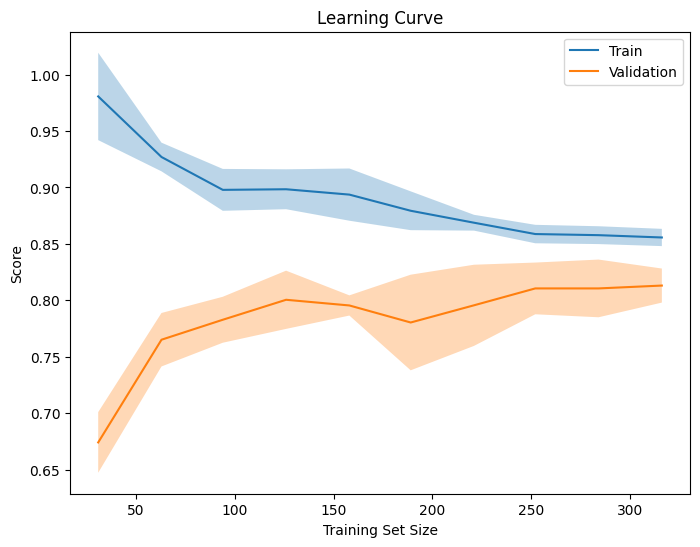

In [26]:
# Función para generar las curvas de aprendizaje
def plot_learning_curve(estimator, X, y, cv, train_sizes):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)

    # Calcular los promedios y las desviaciones estándar de las puntuaciones
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Train')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3)
    plt.plot(train_sizes, val_scores_mean, label='Validation')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.3)
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

# Definir los tamaños de conjunto de entrenamiento a evaluar
train_sizes = np.linspace(0.1, 1.0, 10, 100)

# Generar las curvas de aprendizaje
plot_learning_curve(best_model, X_train, y_train, cv=5, train_sizes=train_sizes)